In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
df = pd.read_csv("AirlineTweets.csv")

In [24]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [25]:
df['text'][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

In [26]:
df = df[['airline_sentiment','text']]

In [27]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [14]:
import plotly.express as px

In [16]:
fig = px.pie(df, names='airline_sentiment')
fig.show()

In [17]:
fig = px.histogram(df, x="airline_sentiment")
fig.show()

In [28]:
df['airline_sentiment_classes'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [29]:
df.head()

,airline_sentiment,text,airline_sentiment_classes
0,neutral,@VirginAmerica What @dhepburn said.,1
1,positive,@VirginAmerica plus you've added commercials t...,2
2,neutral,@VirginAmerica I didn't today... Must mean I n...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [36]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [44]:
p = PorterStemmer()

In [45]:
def my_tokenizer(line):
  line = line.lower().strip()
  token = [p.stem(t) for t in word_tokenize(line) if t not in stopwords.words('english')]
  return token

In [46]:
vectorizer = TfidfVectorizer(max_features = 3000, tokenizer = my_tokenizer)

In [49]:
X = vectorizer.fit_transform(df['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [54]:
X

<14640x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 181909 stored elements in Compressed Sparse Row format>

In [58]:
X = X.toarray()
# Data shouldn't be in sparse matrix for NN

In [59]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15982915, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.24065358, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1414698 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [18]:
from sklearn.model_selection import train_test_split

In [132]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, df['airline_sentiment_classes'], test_size=0.2, random_state=42)

In [103]:
len(Xtrain)

11712

In [104]:
len(Xtest)

2928

In [105]:
len(ytrain)

11712

In [106]:
len(ytest)

2928

In [107]:
X.shape

(14640, 3000)

In [108]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [120]:
from tensorflow.keras.metrics import F1Score

In [110]:
from tensorflow.keras.utils import to_categorical

In [148]:
inputs = Input(shape = (Xtrain.shape[1]))
x = Dense(256, activation = 'relu')(inputs)
x = Dense(128, activation = 'relu')(inputs)
x = Dense(64, activation = 'relu')(x)
output = Dense(3)(x)
model = Model(inputs = inputs, outputs = output, name = 'AirlineSentiment')

In [149]:
model.summary()

Model: "AirlineSentiment"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 3000)]            0         
                                                                 
 dense_31 (Dense)            (None, 128)               384128    
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 3)                 195       
                                                                 
Total params: 392579 (1.50 MB)
Trainable params: 392579 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
ytrain = to_categorical(ytrain, num_classes=3)
ytest = to_categorical(ytest, num_classes=3)

In [152]:
model.compile(
    optimizer = Adam(learning_rate = 0.1),
    loss = CategoricalCrossentropy(from_logits = True),
    metrics = [F1Score()]
)

In [153]:
result = model.fit(
    Xtrain, ytrain,
    validation_data = (Xtest, ytest),
    epochs = 50,
    batch_size = 2048
)

Epoch 1/50
6/6 [==============================] - 5s 382ms/step - loss: 4.3684 - f1_score: 0.4318 - val_loss: 0.7639 - val_f1_score: 0.4057
Epoch 2/50
6/6 [==============================] - 1s 193ms/step - loss: 0.7548 - f1_score: 0.2921 - val_loss: 0.7750 - val_f1_score: 0.4048
Epoch 3/50
6/6 [==============================] - 1s 162ms/step - loss: 0.6619 - f1_score: 0.4816 - val_loss: 0.7184 - val_f1_score: 0.4480
Epoch 4/50
6/6 [==============================] - 1s 151ms/step - loss: 0.5768 - f1_score: 0.4912 - val_loss: 0.7494 - val_f1_score: 0.4619
Epoch 5/50
6/6 [==============================] - 1s 155ms/step - loss: 0.5102 - f1_score: 0.5936 - val_loss: 0.7396 - val_f1_score: 0.6348
Epoch 6/50
6/6 [==============================] - 1s 165ms/step - loss: 0.4159 - f1_score: 0.7514 - val_loss: 0.7989 - val_f1_score: 0.6808
Epoch 7/50
6/6 [==============================] - 1s 100ms/step - loss: 0.3369 - f1_score: 0.8318 - val_loss: 0.8797 - val_f1_score: 0.6895
Epoch 8/50
6/6 [====

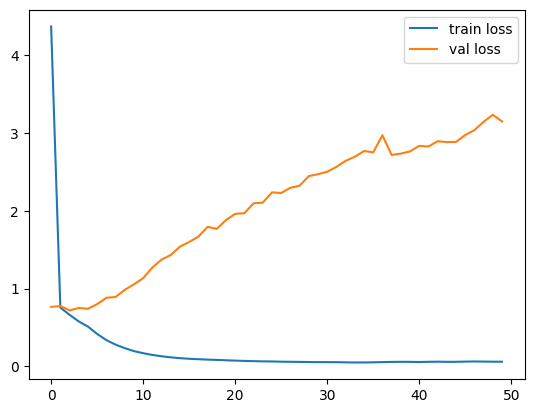

In [154]:
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend();

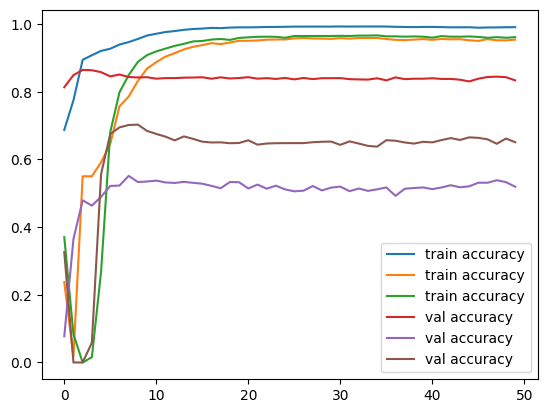

In [155]:
plt.plot(result.history['f1_score'], label='train accuracy')
plt.plot(result.history['val_f1_score'], label='val accuracy')
plt.legend();

In [176]:
P_train = model.predict(Xtrain)
P_test = model.predict(Xtest)

92/92 [==============================] - 1s 5ms/step


In [181]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [182]:
Pr_train = model.predict(Xtrain)
Pr_test = model.predict(Xtest)
print("Train AUC:", roc_auc_score(ytrain, Pr_train))
print("Test AUC:", roc_auc_score(ytest, Pr_test))

92/92 [==============================] - 0s 5ms/step
Train AUC: 0.9927768713348493
Test AUC: 0.8399020049979988


In [184]:
model.layers[1].get_weights()

[array([[-0.09041224, -0.8708404 ,  0.11737959, ..., -0.85479426,
         -0.8601714 , -0.95890784],
        [-0.2717933 , -0.6146567 , -0.18701947, ..., -0.5976001 ,
         -0.5449178 , -0.7054149 ],
        [-0.57187825, -0.51399827, -0.44926506, ..., -0.01763288,
         -0.33082047, -0.63053614],
        ...,
        [-0.27769026,  0.5680724 , -0.00850122, ..., -0.5867078 ,
          0.24993293, -0.5865412 ],
        [-0.15400097, -0.7398284 , -0.50013953, ..., -0.6085962 ,
         -0.5221086 , -0.6201856 ],
        [ 0.7006499 , -0.5004563 , -0.4784344 , ..., -0.02871158,
         -0.5159321 , -0.00978436]], dtype=float32),
 array([-0.4279129 , -0.5821597 , -0.5706751 , -0.9550641 , -0.8182357 ,
        -0.50300986, -0.51903814, -0.34483498, -0.12123409, -0.50952274,
        -0.4354328 , -1.0355732 , -1.0737106 , -0.55293995, -0.4430057 ,
        -0.5832123 , -0.5167142 , -0.46135703, -0.48346514, -0.48532662,
        -0.522388  , -0.41751498, -0.32178655, -0.9112184 , -0.413

In [185]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'@': 236,
 'virginamerica': 2822,
 'said': 2330,
 '.': 22,
 'plu': 2063,
 "'ve": 12,
 'ad': 281,
 'commerci': 745,
 'experi': 1116,
 '...': 24,
 "n't": 1824,
 'today': 2677,
 'must': 1822,
 'mean': 1742,
 'need': 1840,
 'take': 2608,
 'anoth': 360,
 'trip': 2716,
 '!': 0,
 "'s": 11,
 'realli': 2197,
 'blast': 526,
 '``': 244,
 'entertain': 1067,
 "''": 6,
 'guest': 1349,
 "'": 5,
 'face': 1132,
 '&': 4,
 'amp': 348,
 ';': 233,
 'littl': 1656,
 'recours': 2208,
 'big': 511,
 'bad': 459,
 'thing': 2645,
 'serious': 2387,
 'would': 2924,
 'pay': 2004,
 '$': 2,
 '30': 124,
 'flight': 1207,
 'seat': 2363,
 'play': 2058,
 'fli': 1205,
 'va': 2805,
 'ye': 2939,
 ',': 18,
 'nearli': 1838,
 'everi': 1090,
 'time': 2669,
 'vx': 2833,
 '“': 2968,
 'ear': 1022,
 '”': 2969,
 '’': 2967,
 'go': 1315,
 'away': 444,
 ':': 232,
 ')': 14,
 'miss': 1792,
 'prime': 2111,
 'opportun': 1936,
 'without': 2904,
 'hat': 1375,
 'http': 1442,
 'well': 2874,
 'amaz': 339,
 'arriv': 396,
 'hour': 1435,
 'earli': 1